In [3]:
import numpy as np
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow import keras

# Diretórios de dados
base_dir = '../../Imagens/'

train_dir = os.path.join(base_dir, 'train/train5')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

**Load dos dados**

- O valor 1./255 significa que vamos dividir cada valor de pixel por 255. Isso resulta em reescalar os valores de pixel de cada imagem para o intervalo de 0 a 1. 

In [4]:
# Configuração do ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

IMG_SIZE = 32
BATCH_SIZE = 32
num_classes = 10

train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    
)

validation_dataset = datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    
)

test_dataset = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    
)

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


**Arquitetura**
- A data agumentation é usada para melhorar a generalização e robustez do modelo ao introduzir variações nos dados de treino, como *rescalling*, *zoom* etc...

**Regularização L2**
- Aplicamos nas camadas convolucionais e densas para penalizar os pesos grandes na função de *loss* durante o treino, o que ajuda a evitar *overfitting* ao reduzir a complexidade do modelo

**Otimizador**
- O modelo é compilado com o otimizador Adam, que foi o que mais utilizamos nada aulas (optimizer=Adam(learning_rate=0.0001)), e que é amplamente utilizado devido à sua eficiência em ajustar as taxas de aprendizagem de forma adaptativa para cada parâmetro da rede neuronal.

**Função Loss**
- A função de *loss* escolhida foi a categorical_crossentropy, adequada para problemas de classificação multiclasse

**Métrica da avaliação**

- A métrica de avaliação durante o treino foi a acurácia (metrics=['accuracy']), que mede a proporção de *predicts* corretas em relação ao total de previsões

**Layers Convolucionis**
- Cada uma das camadas convolucionais (Conv2D) é seguida pela ativação ReLU (activation='relu'), utilizando padding do tipo 'same' para manter o tamanho da saída igual ao da entrada (padding='same').  
- Além disso, aplicámos regularização do kernel através do kernel_regularizer=l2(0.0001), que aplica regularização L2 para ajudar a evitar overfitting como já explicado anteriormente.
- Após cada camada convolucional, aplicámos normalização de batch (BatchNormalization) para acelerar o treino e melhorar a estabilidade do modelo.
- Posteriormente, é utilizado um pooling máximo (MaxPooling2D) com uma janela de (2, 2) para reduzir a dimensionalidade dos dados e extrair características mais importantes da imagem.

**Camada Flatten**
- Transforma a saída das camadas convolucionais em um vetor unidimensional para ligar a parte convolucional à *fully connected* da rede

**Camadas Fully Connected**

- A primeira camada densa (Dense) com 512 unidades, ativação ReLU, e regularização do kernel através do kernel_regularizer=l2(0.001).
Normalização de batch (BatchNormalization) e dropout de 30% (Dropout(0.3)) para a regularização e prevenção do *overfitting*.

In [6]:
# Definindo o input
inputs = Input(shape=(32, 32, 3))

# Primeira camada convolucional
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Segunda camada convolucional
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Terceira camada convolucional
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Quarta camada convolucional
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Camada de Flatten
x = layers.Flatten()(x)

# Camada totalmente conectada
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Camada de saída
outputs = layers.Dense(10, activation='softmax')(x)  # Supondo 10 classes

# Definindo o modelo
model = Model(inputs=inputs, outputs=outputs)

# Compilando o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496 

**Callbacks**

- Uma mais valia para os treinos que fizemos foi o early_stopping que, se o val_loss nao mudar durante 10 epocas ele parar de treinar e fica com os melhores pesos que teve
- ReduceLr vai reduzindo o lr se mantiver o val_loss com 0.1 durante 5 vezes

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001)

In [9]:
# Treinar o modelo
history = model.fit(train_dataset, epochs=100 ,validation_data=validation_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/100


1250/1250 [==============================] - 48s 37ms/step - loss: 2.9140 - accuracy: 0.3518 - val_loss: 2.7124 - val_accuracy: 0.3726 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - 32s 26ms/step - loss: 2.1544 - accuracy: 0.4887 - val_loss: 2.0665 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - 33s 26ms/step - loss: 1.8887 - accuracy: 0.5470 - val_loss: 1.8090 - val_accuracy: 0.5859 - lr: 0.0010
Epoch 4/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.7853 - accuracy: 0.5810 - val_loss: 1.8056 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 5/100
1250/1250 [==============================] - 32s 25ms/step - loss: 1.7666 - accuracy: 0.6015 - val_loss: 2.1665 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 6/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.7488 - accuracy: 0.6225 - val_loss: 1.5829 - val_accuracy: 0.6864 - lr: 0.0010
Epoch 7/100
1250/1250 [===============

In [10]:
#Saving the model
model.save('From_Scratch_Sem_DataAugmentation.h5')

c:\Users\MvCrespo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
model = keras.models.load_model('From_Scratch_Sem_DataAugmentation.h5')
# Validacao da Rede
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

# Avaliar o modelo
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 4s 12ms/step - loss: 0.6394 - accuracy: 0.8435
val_acc: 0.843500018119812
313/313 [==============================] - 4s 11ms/step - loss: 0.6599 - accuracy: 0.8439
Test accuracy: 0.8439000248908997


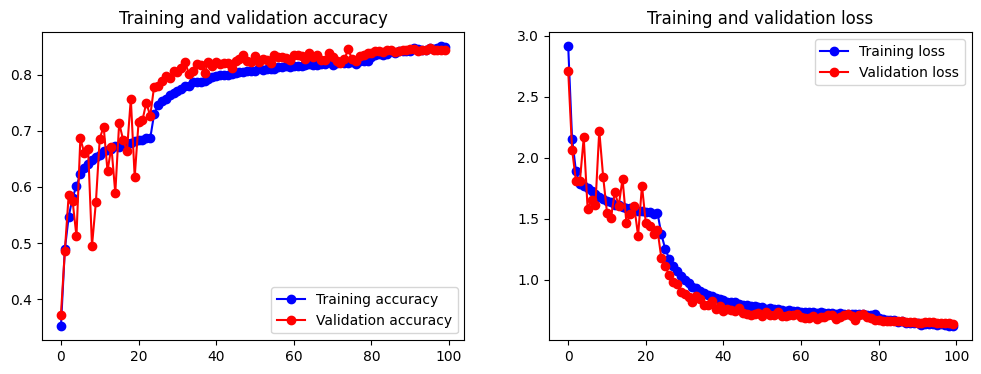

In [12]:
# Plotando os resultados
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)